In [1]:
import sys
sys.path.append("../scripts/")
from GridMap import *
import math
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [2]:
class Astar():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.cost_map = np.full(self.grid_map.shape, 1)    #その地点が持つコスト
        self.id_map = np.full(self.grid_map.shape, 0)
        self.parent_id_map = np.full(self.grid_map.shape, 0)
        self.flag_path_draw = 0  #経路描画のフラグ
        
        self.open_list = []
        self.closed_list = []
        
        index = 0
        for index_x, grids in enumerate(self.grid_map):
            for index_y, grid in enumerate(grids):
                self.id_map[index_x][index_y] = index;
                if(grid == '2'):
                    self.open_list.append([index, 0, 0])
                index += 1
    
    def draw(self, ax, elems):
        if not(self.isClosed(self.world.goal_index)): #ゴールにたどり着いていなければコストを計算
            val = np.argmin(self.open_list, axis=0) #評価マップの中から最も小さいもの抽出
            grid_id, cost_f, cost_g = self.open_list[val[1]]
            index = [np.where(self.id_map==grid_id)[0][0], np.where(self.id_map==grid_id)[1][0]]
            self.open_list.remove([grid_id, cost_f, cost_g])  #オープンリストから削除
            self.closed_list.append([grid_id, cost_f, cost_g])  #クローズドリストに追加
            
            #コストの描画
            if(self.world.grid_map[index[0]][index[1]] != '2' and self.world.grid_map[index[0]][index[1]] != '3'):
                c = "blue"
                fill = False
                alpha = 1.0
                
                #評価をカラーマップに出力する場合はこの部分のコメントをアウトを外す
                cost_adj1, cost_adj2 = 55.0, 36.35    #map1
                #cost_adj1, cost_adj2 = 11.0, 27.9    #map2
                #cost_adj1, cost_adj2 = 6.0, 27.9    #map3
                c_num = int(cost_adj1 * (cost_f - cost_adj2)) #Black→Blue
                #print(cost_f, c_num)
                if(c_num > 0xff): #Blue → Cyan
                    c_num = (c_num-0xff)*256 + 0xff
                    if(c_num > 0xffff): #Cyan → Green
                        c_num = 0xffff - int((c_num-0x100ff)*1/256)
                        if(c_num < 0xff00): #Green →Yellow
                            c_num = (0xff00-c_num)*65536+0xff00
                            if(c_num > 0xffff00): #Yellow → Red
                                c_num = 0xffff00 - int((c_num-0xffff00)*0.5/65536)*256
                fill = True
                alpha = 0.5
                c = '#' + format(int(c_num), 'x').zfill(6)
                
                #print(c, cost_f)
                r = patches.Rectangle(
                    xy=((index[0])*self.world.grid_step[0], (index[1])*self.world.grid_step[1]),
                    height=self.world.grid_step[0],
                    width=self.world.grid_step[1],
                    color=c,
                    fill=fill,
                    alpha=alpha
                )
                ax.add_patch(r)
            
            #コストの計算
            for n in self.listNeigbor(index):
                evaluation_f = cost_g + self.cost(n) + self.c(n, index) + self.h(n)    #評価を計算
                if(self.isOpened(n)): #オープンリストに含まれているか
                    its_index, its_cost_f, its_cost_g = self.open_list[[val[0] for val in self.open_list].index(self.id(n))]
                    if(its_cost_f > evaluation_f): #評価が更新されなければ繰り返しを戻す
                        self.open_list.remove([its_index, its_cost_f, its_cost_g])
                    else:
                        continue;
                elif(self.isClosed(n)): #クローズドリストに含まれているか 
                    its_index, its_cost_f, its_cost_g = self.closed_list[[val[0] for val in self.closed_list].index(self.id(n))]
                    if(its_cost_f > evaluation_f):
                        self.closed_list.remove([its_index, its_cost_f, its_cost_g])  
                    else:
                        continue;
                self.parent_id_map[n[0]][n[1]] = self.id(index)
                self.open_list.append([self.id(n), evaluation_f, evaluation_f - self.h(n)])
        else:
            #経路の描画
            if(self.flag_path_draw == 0):
                parent_id = self.b(self.world.goal_index)
                while(parent_id != self.id(self.world.start_index)):
                    parent = np.where(self.id_map==parent_id)
                    parent_id = self.b(parent)
                    r = patches.Rectangle(
                        xy=((parent[0])*self.world.grid_step[0], (parent[1])*self.world.grid_step[1]),
                        height=self.world.grid_step[0],
                        width=self.world.grid_step[1],
                        color="red",
                        fill=True,
                        alpha=0.5
                    )
                    ax.add_patch(r)
                self.flag_path_draw = 1
                
    def listNeigbor(self, index):
        neigbor_index = []
        for i in range(-1, 2):
            if(index[0]+i<0 or index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                continue;
            for j in range(-1, 2):
                if(index[1]+j<0 or index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                    continue;
                if(i==0 and j==0): #自分か
                    continue;
                elif(self.grid_map[index[0]+i][index[1]+j] == '0'): #障害物か
                    continue;
                else:
                    neigbor_index.append([index[0]+i, index[1]+j])
        return neigbor_index
    
    def isOpened(self, u):
        return self.id(u) in [val[0] for val in self.open_list]
    
    def isClosed(self, u):
        return self.id(u) in [val[0] for val in self.closed_list]
    
    def id(self, u):
        return self.id_map[u[0]][u[1]]
    
    def h(self, u):
        return 1*math.sqrt((self.world.goal_index[0]-u[0])**2+(self.world.goal_index[1]-u[1])**2)
    
    def cost(self, u):
        return self.cost_map[u[0]][u[1]]
    
    def b(self, u):
        return self.parent_id_map[int(u[0])][int(u[1])]
    
    def c(self, u, v):
        return 1*math.sqrt((u[0]- v[0])**2+(u[1]-v[1])**2)

<IPython.core.display.Javascript object>


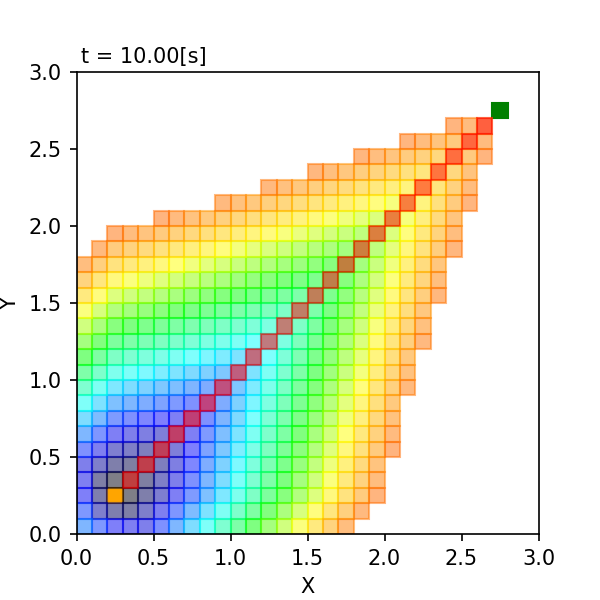

In [3]:
if __name__ == "__main__":
    time_span = 10
    time_interval = 0.01
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map1.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(Astar(world))
    
    world.draw()
    #world.ani.save('astar_map1.gif', writer='pillow', fps=100)    #アニメーション保存